In this notebook i will train the model that i will try to attack. 

The model is classify toxic comments using BERT.


# Let's install needed files

In [ ]:
!pip install transformers
!unzip /content/drive/MyDrive/Innopolis/SiML/Project/jigsaw-toxic-comment-classification-challenge.zip
!unzip train.csv.zip;

In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertModel

from tqdm import tqdm


device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [3]:
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


# Data preprocessing

Fistly, let's check our dataset.

In [4]:
import os

path = "./"
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Divide it into train and validation datasets.

In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.05)

We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. Let's use PyTorch's data primitives: ```torch.utils.data.DataLoader``` and ```torch.utils.data.Dataset```.

In [6]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series):
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True)
        tokens = tokens[:119] + [tokens[-1]] if len(tokens) > 120 else tokens
        x = torch.LongTensor(tokens)

        labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        y = torch.FloatTensor(row[labels])
        return x, y
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        return self.row_to_tensor(self.tokenizer, self.df.iloc[index])

In [7]:
from functools import partial
from torch.nn.utils.rnn import pad_sequence

# merges a list of samples to form a mini-batch of Tensors
def collate_fn(batch, device: torch.device):
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

collate_fn = partial(collate_fn, device=device)

In [8]:
bert_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = ToxicDataset(tokenizer, train_df)
val_dataset = ToxicDataset(tokenizer, val_df)

BATCH_SIZE = 32
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(val_dataset)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            sampler=train_sampler, collate_fn=collate_fn)

val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          sampler=dev_sampler, collate_fn=collate_fn)

# Build the model

So, my model's architecture will looks like this.


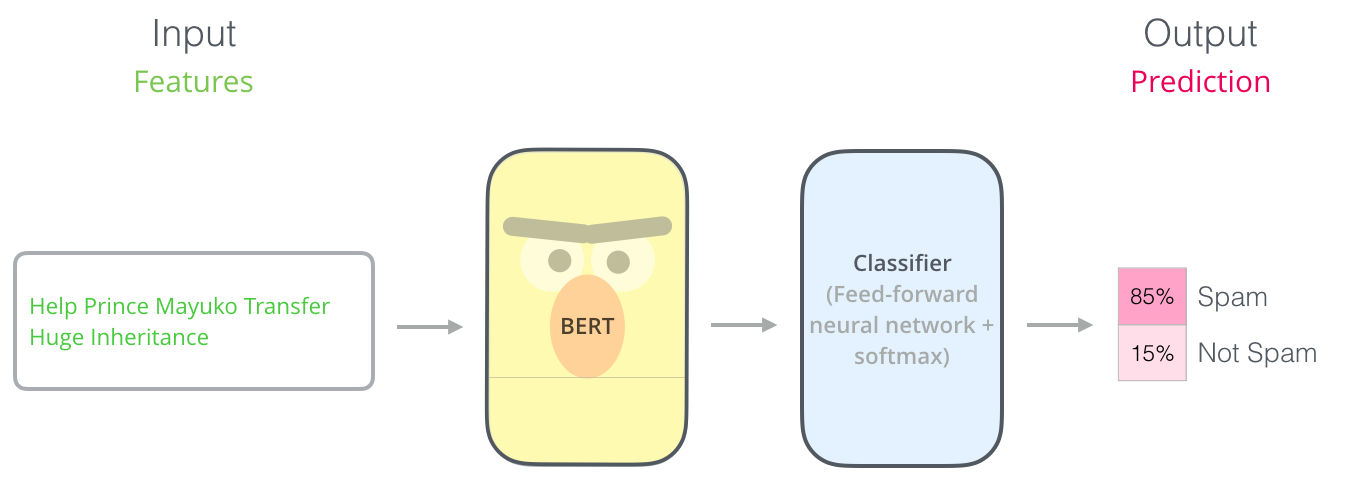

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None):
      
        x = self.bert(input_ids, attention_mask=attention_mask)
        cls_x = x[1] # sentence embedding
        cls_x = self.classifier(cls_x)
        out = torch.sigmoid(cls_x)

        return out

bert = BertModel.from_pretrained(bert_model_name)

In [19]:
model = BertClassifier(bert, 6).to(device)

# Train process

In [20]:
from sklearn.metrics import roc_auc_score

def train(model, iterator, optimizer, scheduler, loss_func):
    model.train()
    total_loss = 0

    iteration = 0
    for x, y in tqdm(iterator):
        iteration += 1
        optimizer.zero_grad()
        mask = (x != 0).float()
        outputs = model(x, attention_mask=mask)
        loss = loss_func(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if iteration % 500 == 0:
            print(f"\n\nEVALUATING at iteration - {iteration}")
            evaluate(model, val_iterator)

    print(f"Train loss {total_loss / len(iterator)}\n")

def evaluate(model, iterator):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in iterator:
            mask = (x != 0).float()
            outputs = model(x, attention_mask=mask)
            loss = loss_func(outputs, y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)

    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print("\nROC_AUC for labels:")
    for i, name in enumerate(labels):
        print(f" * {name} - {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"\nEVALUATE LOSS -  {total_loss / len(iterator)}\n")

In [21]:
from transformers import get_linear_schedule_with_warmup

EPOCH_NUM = 1

loss_func = nn.BCELoss()

lr = 2e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)

# The triangle learning rate advances linearly until half of the first epoch, then linearly decays.
w_steps = 10 ** 3
t_steps = len(train_iterator) * EPOCH_NUM - w_steps
scheduler = get_linear_schedule_with_warmup(optimizer, w_steps, t_steps)

In [22]:
for i in range(EPOCH_NUM):
    print('=' * 50, f"EPOCH {i}", '=' * 50)
    print("\nTRAINING\n")
    train(model, train_iterator, optimizer, scheduler, loss_func)
    print("\nEVALUATING\n")
    evaluate(model, val_iterator)

================================================== EPOCH 0 ==================================================

TRAINING



 11%|█         | 499/4738 [05:53<49:41,  1.42it/s]



EVALUATING at iteration - 500


 11%|█         | 500/4738 [07:06<26:36:24, 22.60s/it]


ROC_AUC for labels:
 * toxic - 0.9681443981431963
 * severe_toxic - 0.9632406308683079
 * obscene - 0.970315602108578
 * threat - 0.9114655353027445
 * insult - 0.949900788640119
 * identity_hate - 0.890045039356821

EVALUATE LOSS -  0.0822308138012886



 21%|██        | 999/4738 [12:54<43:03,  1.45it/s]



EVALUATING at iteration - 1000


 21%|██        | 1000/4738 [14:08<23:42:27, 22.83s/it]


ROC_AUC for labels:
 * toxic - 0.9787272167901876
 * severe_toxic - 0.9767759011992949
 * obscene - 0.9831636495222447
 * threat - 0.9297140163419235
 * insult - 0.9812620406514038
 * identity_hate - 0.9449404386075682

EVALUATE LOSS -  0.054683808237314224



 32%|███▏      | 1499/4738 [19:56<37:37,  1.43it/s]



EVALUATING at iteration - 1500


 32%|███▏      | 1500/4738 [21:11<20:34:52, 22.88s/it]


ROC_AUC for labels:
 * toxic - 0.9800993461342378
 * severe_toxic - 0.9744055368025714
 * obscene - 0.9868885433272371
 * threat - 0.9326628954535932
 * insult - 0.9819139494779677
 * identity_hate - 0.969339563076146

EVALUATE LOSS -  0.04803885892033577



 42%|████▏     | 1999/4738 [26:57<32:41,  1.40it/s]



EVALUATING at iteration - 2000


 42%|████▏     | 2000/4738 [28:11<17:15:37, 22.69s/it]


ROC_AUC for labels:
 * toxic - 0.9834609343785481
 * severe_toxic - 0.9842801350214859
 * obscene - 0.9891314340482548
 * threat - 0.9681332495285984
 * insult - 0.985484476127943
 * identity_hate - 0.978301132297849

EVALUATE LOSS -  0.04813696816563606



 53%|█████▎    | 2499/4738 [33:58<25:38,  1.46it/s]



EVALUATING at iteration - 2500


 53%|█████▎    | 2500/4738 [35:13<14:13:02, 22.87s/it]


ROC_AUC for labels:
 * toxic - 0.9846296151311351
 * severe_toxic - 0.9875332657457864
 * obscene - 0.9898300553876648
 * threat - 0.9733134297087784
 * insult - 0.9856630565757291
 * identity_hate - 0.9823062676263838

EVALUATE LOSS -  0.04508443921804428



 63%|██████▎   | 2999/4738 [41:00<19:12,  1.51it/s]



EVALUATING at iteration - 3000


 63%|██████▎   | 3000/4738 [42:15<10:59:55, 22.78s/it]


ROC_AUC for labels:
 * toxic - 0.9851771068691375
 * severe_toxic - 0.9873114941072109
 * obscene - 0.9897302989108289
 * threat - 0.9822491095746909
 * insult - 0.9863164084766187
 * identity_hate - 0.9849917918929157

EVALUATE LOSS -  0.041790857911109924



 74%|███████▍  | 3499/4738 [48:00<15:04,  1.37it/s]



EVALUATING at iteration - 3500


 74%|███████▍  | 3500/4738 [49:14<7:47:08, 22.64s/it]


ROC_AUC for labels:
 * toxic - 0.9856645013267347
 * severe_toxic - 0.9823345929194365
 * obscene - 0.990383932035195
 * threat - 0.9855436832181018
 * insult - 0.9859484245236051
 * identity_hate - 0.9864945068821822

EVALUATE LOSS -  0.04144858196377754



 84%|████████▍ | 3999/4738 [55:00<08:26,  1.46it/s]



EVALUATING at iteration - 4000


 84%|████████▍ | 4000/4738 [56:14<4:37:55, 22.60s/it]


ROC_AUC for labels:
 * toxic - 0.9858727282952331
 * severe_toxic - 0.9837890692503544
 * obscene - 0.9905068346226694
 * threat - 0.9859888958726168
 * insult - 0.986188696398808
 * identity_hate - 0.9860546365281811

EVALUATE LOSS -  0.040934622287750244



 95%|█████████▍| 4499/4738 [1:02:05<02:46,  1.44it/s]



EVALUATING at iteration - 4500


 95%|█████████▍| 4500/4738 [1:03:19<1:30:05, 22.71s/it]


ROC_AUC for labels:
 * toxic - 0.9858727282952331
 * severe_toxic - 0.9837890692503544
 * obscene - 0.9905068346226694
 * threat - 0.9859888958726168
 * insult - 0.986188696398808
 * identity_hate - 0.9860546365281811

EVALUATE LOSS -  0.04100417718291283



100%|██████████| 4738/4738 [1:06:04<00:00,  1.19it/s]


Train loss 0.06994865615297866


EVALUATING


ROC_AUC for labels:
 * toxic - 0.9858727282952331
 * severe_toxic - 0.9837890692503544
 * obscene - 0.9905068346226694
 * threat - 0.9859888958726168
 * insult - 0.986188696398808
 * identity_hate - 0.9860546365281811

EVALUATE LOSS -  0.040832530707120895



In [32]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Innopolis/SiML/Project/model.pt")